In [1]:
import numpy as np
import numba as nb
import pylab as pl

from numba import jit
import numpy.linalg as la

In [2]:
ngrid = 32

In [3]:
cellsize = 200. / ngrid
cellsize

6.25

In [4]:
pos = np.loadtxt('./data/TracingTheCosmicWeb_PublicData/fof_catalog_200Mpc512.txt', skiprows=3, usecols=[1,2,3])
N_real = len(pos)

In [5]:
volume = 2.e2 ** 3 # 200Mpc **3
volume

8000000.0

In [6]:
meandensity = len(pos) / volume
meandensity

0.035183125

In [7]:
density, bins = np.histogramdd(pos, bins=ngrid, range=None, normed=None, weights=None, density=None)
density.shape

(32, 32, 32)

In [8]:
deltas = (density / meandensity) - 1.
# delta

In [9]:
def Wg(k2, R):
    return np.exp(-k2*R*R/2.)

def get_fourier_smooth(density,R_smooth,N_dim,Lbox):
    karr = np.fft.fftfreq(N_dim, d=Lbox/(2*np.pi*N_dim))
    d_four = np.fft.fftn(density)
    del density
    
    #dksmo = np.zeros(shape=(N_dim, N_dim, N_dim),dtype=complex)
    ksq = np.zeros(shape=(N_dim, N_dim, N_dim),dtype=complex)
    ksq[:,:,:] = karr[None,None,:]**2+karr[None,:,None]**2+karr[:,None,None]**2
    d_four[:,:,:] = Wg(ksq,R_smooth)*d_four

    return karr, ksq, d_four

In [10]:
karr, ksd, d_four = get_fourier_smooth(deltas, R_smooth=8., N_dim=ngrid, Lbox=200.)

In [11]:
ksd.shape

(32, 32, 32)

In [12]:
@jit(nopython=True)
def get_tidal_field(dfour,karr,N_dim):
    tfour = np.zeros(shape=(N_dim, N_dim, N_dim, 3, 3), dtype=nb.complex128)
    
    # computing tidal tensor and phi in fourier space
    # and smoothing using the window functions
    for a in range(N_dim):
        for b in range(N_dim):
            for c in range(N_dim):
                if (a, b, c) == (0, 0, 0):
                    pass
                else:
                    ksq = karr[a]**2 + karr[b]**2 + karr[c]**2
                    # all 9 components
                    tfour[a, b, c, 0, 0] = karr[a]*karr[a]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 1, 1] = karr[b]*karr[b]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 2, 2] = karr[c]*karr[c]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 1, 0] = karr[a]*karr[b]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 0, 1] = tfour[a, b, c, 1, 0]
                    tfour[a, b, c, 2, 0] = karr[a]*karr[c]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 0, 2] = tfour[a, b, c, 2, 0]
                    tfour[a, b, c, 1, 2] = karr[b]*karr[c]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 2, 1] = tfour[a, b, c, 1, 2]

    return tfour

In [13]:
tidal_tilde = get_tidal_field(d_four,karr,ngrid)
# tidal_tilde

In [14]:
tidal_real = np.zeros(shape=(ngrid, ngrid, ngrid, 3, 3),dtype=float) # Normalized by 4. * np.pi * 6.6743e-11

In [15]:
for i in range(3):
    for j in range(3):
        tidal_real[:,:,:,i,j] = np.real(np.fft.ifftn(tidal_tilde[:,:,:,i,j]))

In [16]:
def get_eig(tidt, N_dim):
    evals = np.zeros(shape=(N_dim, N_dim, N_dim, 3))

    for x in range(N_dim):
        for y in range(N_dim):
            for z in range(N_dim):
                # comute and sort evalues in ascending order, for descending add after argsort()[::-1]
                evals[x, y, z, :], evects = la.eig(tidt[x, y, z, :, :])
                idx = evals[x, y, z, :].argsort()
                evals[x, y, z] = evals[x, y, z, idx]
                #evects = evects[:, idx]
    
    lambda1 = evals[:,:,:,0]
    lambda2 = evals[:,:,:,1]
    lambda3 = evals[:,:,:,2]

    return lambda1, lambda2, lambda3

In [17]:
lambda1, lambda2, lambda3 = get_eig(tidal_real, ngrid)

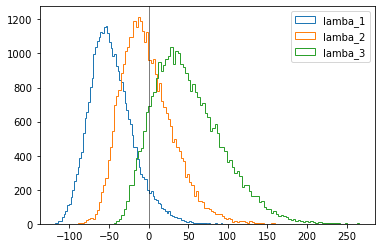

In [18]:
_ = pl.hist(lambda1.flatten(), histtype='step', bins=100, label='lamba_1')
_ = pl.hist(lambda2.flatten(), histtype='step', bins=100, label='lamba_2')
_ = pl.hist(lambda3.flatten(), histtype='step', bins=100, label='lamba_3')

pl.axvline(0.2, c='k', lw=0.5)
pl.legend()

In [25]:
lth = 0.2

ii_box = (pos[:,0]//cellsize).astype(int)
jj_box = (pos[:,1]//cellsize).astype(int)
kk_box = (pos[:,2]//cellsize).astype(int)

lambda1_halo = lambda1[ii_box, jj_box, kk_box]
lambda2_halo = lambda2[ii_box, jj_box, kk_box]
lambda3_halo = lambda3[ii_box, jj_box, kk_box]

environment = np.zeros(len(pos), dtype=int)

# Attached the environment to the galaxies
ii_void = (lambda1_halo < lth) & (lambda2_halo < lth) & (lambda3_halo < lth)
ii_sheet = (lambda3_halo > lth) & (lambda2_halo < lth) & (lambda1_halo < lth)
ii_filament = (lambda3_halo > lth) & (lambda2_halo > lth) & (lambda1_halo < lth)
ii_peak = (lambda1_halo > lth) & (lambda2_halo > lth) & (lambda3_halo > lth)
environment[ii_void] = 3
environment[ii_sheet] = 2        
environment[ii_filament] = 1        
environment[ii_peak] = 0

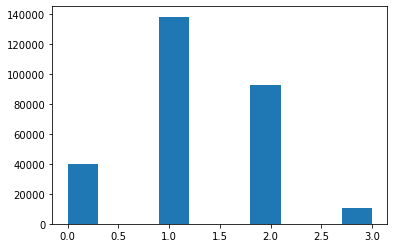

In [26]:
_ = pl.hist(environment)

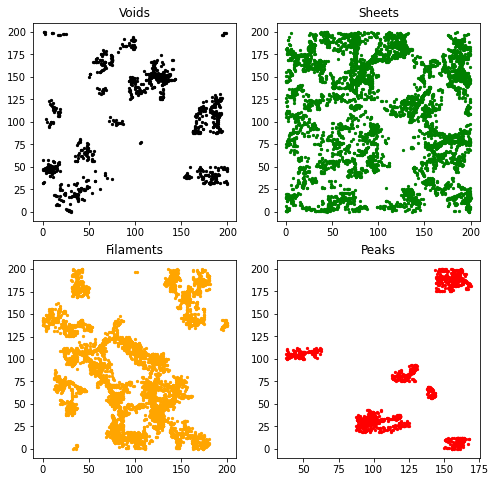

In [27]:
is_slice = (pos[:,2] < 100.)  &   (pos[:,2] > 88.) #Mpc
is_void     = environment == 3
is_sheet    = environment == 2
is_filament = environment == 1
is_peak     = environment == 0

fig = pl.figure(figsize=(8,8))
pl.subplot(2,2,1)
pl.scatter(pos[:,0][is_void & is_slice] , pos[:,1][is_void & is_slice], s=5, c='k')
pl.title('Voids')

pl.subplot(2,2,2)
pl.scatter(pos[:,0][is_sheet & is_slice] , pos[:,1][is_sheet & is_slice], s=5, c='g')
pl.title('Sheets')

pl.subplot(2,2,3)
pl.scatter(pos[:,0][is_filament & is_slice] , pos[:,1][is_filament & is_slice], s=5, c='orange')
pl.title('Filaments')

pl.subplot(2,2,4)
pl.scatter(pos[:,0][is_peak & is_slice] , pos[:,1][is_peak & is_slice], s=5, c='r')
pl.title('Peaks')
pl.show()

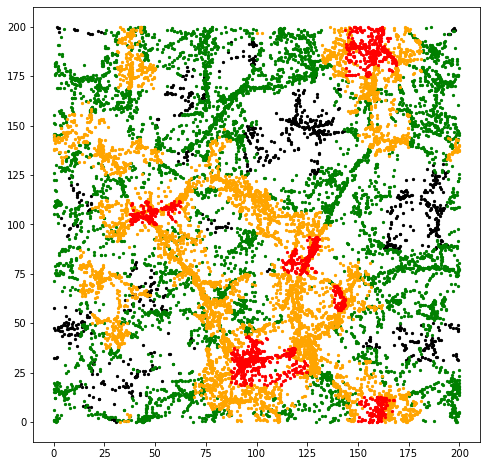

In [28]:
fig = pl.figure(figsize=(8,8))

pl.scatter(pos[:,0][is_void & is_slice] , pos[:,1][is_void & is_slice], s=5, c='k')
pl.scatter(pos[:,0][is_sheet & is_slice] , pos[:,1][is_sheet & is_slice], s=5, c='g')
pl.scatter(pos[:,0][is_filament & is_slice] , pos[:,1][is_filament & is_slice], s=5, c='orange')
pl.scatter(pos[:,0][is_peak & is_slice] , pos[:,1][is_peak & is_slice], s=5, c='r')
pl.show()